# IKpy Quickstart #

Import the IKPy module : 

In [1]:
import ikpy.chain
import numpy as np
import math
import random
import scipy
import ikpy.utils.plot as plot_utils

The basic element of IKPy is the kinematic `Chain`.
To create a chain from an URDF file : 

In [2]:
my_chain = ikpy.chain.Chain.from_urdf_file("./ur5/ur5_gripper.urdf")

/home/Parker/Programming/Robotics/lab-2-ik/.pixi/envs/default/lib/python3.12/site-packages/ikpy/chain.py:60: UserWarning: Link Base link (index: 0) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive".format(link.name, link_index))
/home/Parker/Programming/Robotics/lab-2-ik/.pixi/envs/default/lib/python3.12/site-packages/ikpy/chain.py:60: UserWarning: Link ee_fixed_joint (index: 7) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is as it were inactive
  warnings.warn("Link {} (index: {}) is of type 'fixed' but set as active in the active_links_mask. In practice, this fixed link doesn't provide any transformation so is a

# Inverse kinematics

In Inverse Kinematics, you want your kinematic chain to reach a 3D position in space.

To have a more general representation of position, IKPy works with homogeneous coordinates. Homogenous coordinates are represented as a 4x4 matrix storing both position and orientation. Here we only consider (x,y,z) position, not orientation of the chain.

In [3]:
target_position = [ 0.1, -0.2, 0.1]

In [4]:
print("The joint angles are : ", my_chain.inverse_kinematics(target_position))

The joint angles are :  [ 0.         -1.5551666  -1.20894748  2.32791448 -0.53210037 -1.72066457
  0.          0.        ]


You can check that the Inverse Kinematics is correct by comparing with the original position vector : 

In [5]:
real_frame = my_chain.forward_kinematics(my_chain.inverse_kinematics(target_position))
print("Computed position vector : %s, goal position vector : %s" % (real_frame[:3, 3], target_position))

Computed position vector : [ 0.1 -0.2  0.1], goal position vector : [0.1, -0.2, 0.1]


# Plotting
And finally plot the result : 

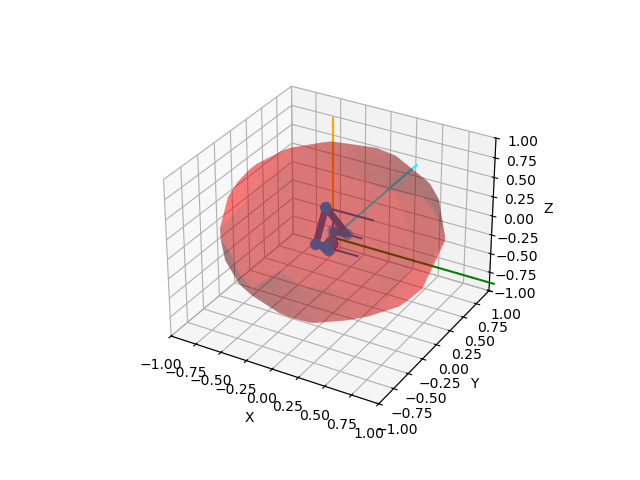

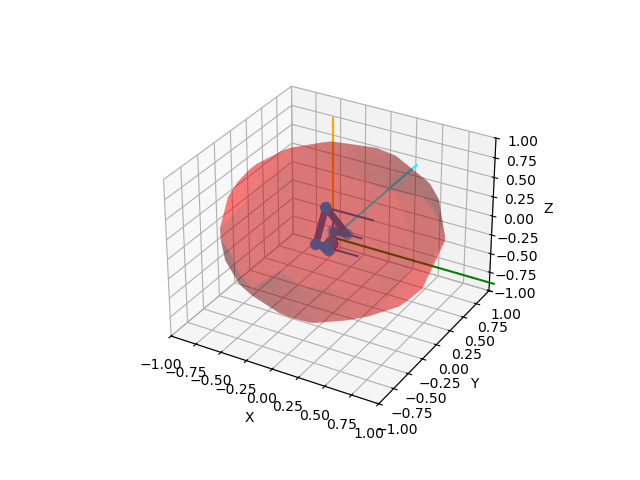

In [6]:
%matplotlib notebook
%matplotlib ipympl

import matplotlib.pyplot as plt


fig, ax = plot_utils.init_3d_figure()
my_chain.plot(my_chain.inverse_kinematics(target_position), ax, target=target_position)

# Inverse Transform Sampling
def sample_sphere_surface():
    phi = random.uniform(0, 2*math.pi)
    # Used to counteract the jacobian factor for spherical point selection. Corresponds with theta/pitch.
    u = random.random()
    z = 1-(2*u)
    rad = math.sqrt(1-(z**2))
    x = rad * math.cos(phi)
    y = rad * math.sin(phi)
    return [x, y, z]

# Returns a list containing n entries of sampled arm positions when trying to reach uniformly distributed points on a sphere.
def sample_reach(n):
    samples = []
    for i in range(n):
        sampled_point = sample_sphere_surface()
        reached_point = my_chain.forward_kinematics(my_chain.inverse_kinematics(sampled_point))[:3, 3]
        samples.append(reached_point)
    return samples
    

# Create a convex hull of the robot's reach and display it on the plot.
samples = 300
furthest_reached_points = np.array(sample_reach(samples))
hull = scipy.spatial.ConvexHull(furthest_reached_points)
for simplex in hull.simplices:
    tri = furthest_reached_points[simplex]
    ax.plot_trisurf(tri[:,0], tri[:,1], tri[:,2], color="red", alpha=0.3)

fig.show()